In [223]:
from __future__ import absolute_import

#check if there is an evirronment variable called ROOT_PATH
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

# import local_settings
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from dsp_utils import parse_samples

from runners import Runner


In [224]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 400
TfN2 = 300

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

playlist = {
'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
'frogs_long': [(P0,TfN1),((P0,Pplus),2*TfA),(P0,TfN2)],
'anti_frogs_long': [(P0,TfN1),(Pplus,2*TfA),(P0,TfN2)],
# 'savings': 2 * [(P0, TsA), (Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
'savings': [(P0, TsA), (Pplus, TsA),(P0, 2000),(Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 140)],
'evrecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 2),
               (Pplus, 2),
               (Pchannel, 140)],
'spOVRrecovery': [(P0, 50),
               (Pplus, 450),
               (Pminus, 15),
               (Pchannel, 140)],
'spOVRrecovery_ref': [(P0, 50),
               (Pplus, 150),
               (Pminus, 15),
               (Pchannel, 140)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 384),
#                (Pchannel, 400)],    
# 'AB0':[(P0, TaN),(Pminus, TaB)],
# 'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
# 'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
# 'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
# 'ANB0':[(P0, TaN),(Pminus, TaB)],
# 'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
# 'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
# 'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [225]:
# frog_playlist = {
# f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

# frog_playlist_a = {
# f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

# frog_playlist.update(frog_playlist_a)

In [226]:
test_vec= np.stack([np.zeros(200),
                    np.zeros(200),
                    np.zeros(200),
                   np.linspace(2*Pminus,2*Pplus,200)]).T

x_test = test_vec[:,-1]


In [227]:
cnt =0

results = {}
ws =  [0.25] #[0.05,0.1,0.2,0.5,1,2]
skips = [0.0, 0.3] #[0, 0.2, 0.5]
for s, skip in enumerate(skips):
    for i, w in enumerate(ws):
        model_construct_args =  dict(n_inputs = 4,
                          n_hidden = 5*4*512,
                          n_outs = 1,
                          en_bias = False,
                         b_high=w, first_layer_init='uniform_unity',
                        first_layer_weights_trainable = True,
                        out_layer_init='zeros',
                        post_activation_bias = None,
                        post_activation_bias_scale = 0,
                          nl = 'relu', skip_gain= skip)
        setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':0.7e-5, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True}
        runner = Runner(model_construct_args=model_construct_args,
                        test_vec=test_vec,
                        **setting)
        results[(s,i)] = runner.run_multiple(playlist)

running scenario: frogs
running scenario: anti_frogs
running scenario: frogs_long
running scenario: anti_frogs_long
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: spOVRrecovery
running scenario: spOVRrecovery_ref
running scenario: herzfeld,z=0.1
running scenario: herzfeld,z=0.5
running scenario: herzfeld,z=0.9
running scenario: frogs
running scenario: anti_frogs
running scenario: frogs_long
running scenario: anti_frogs_long
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: spOVRrecovery
running scenario: spOVRrecovery_ref
running scenario: herzfeld,z=0.1
running scenario: herzfeld,z=0.5
running scenario: herzfeld,z=0.9


In [228]:
def do_plots(results,playlist,figsize=(18, 6)):
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.ylim([1.5*Pminus,1.5*Pplus])


    plt.subplot(1,3,2)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    plt.ylim([1.5*Pminus,1.5*Pplus])


    plt.subplot(1,3,3)
    
    times = [1, 170, 185]
    colors = ['tab:red','tab:blue','tab:orange','tab:green']
    paradigm = 'sprecovery'
    plt.plot(x_test,x_test,'k:')
    for i,time in enumerate(times):
        u_test = results[paradigm].test_output[time]
        plt.plot(x_test,u_test,colors[i])
        u_t = results[paradigm].u_lp[time]
        plt.plot(u_t, u_test[np.argmin(np.abs(x_test-u_t))],'*',color=colors[i])
    plt.ylim([1.5*Pminus,1.5*Pplus])


    # for t in [170,185]:
    #     plt.plot(results['sprecovery'].test_output[t])
    # plt.show()

In [229]:
def do_plots_full(results,playlist,figsize=(24, 12)):
    plt.figure(figsize=figsize)
    plt.subplot(2,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=3,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.subplot(2,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.0])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(2,3,3)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,4)
    plot_by_key(results,
                ['spOVRrecovery','spOVRrecovery_ref'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )


    plt.subplot(2,3,5)
    plot_by_key(results, ['frogs_long','anti_frogs_long'],visu_offsets = [0, 0.0])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')

    # plt.subplot(2,3,4)
    # plot_by_key(results,
    #             ['AB0','AB1','AB2','AB3'],
    #             colors=['tab:red','tab:blue','tab:orange','tab:green'],
    #             align_end=True,
    #             visu_offsets=[0]*10,
    #            )
    
    # plt.subplot(2,3,5)
    # plot_by_key(results,
    #             ['ANB0','ANB1','ANB2','ANB3'],
    #             colors=['tab:red','tab:blue','tab:orange','tab:green'],
    #             align_end=True,
    #             visu_offsets=[0]*10,
    #            )
    
    plt.subplot(2,3,6)
    for iz, z in enumerate(hrz_params['z_list']):
        deltas = []
        scenario = f'herzfeld,z={z}'
        this_result = results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')
    plt.legend(loc='upper right')
    plt.xlabel('block #')
    plt.ylabel('adaptation delta channel2-channel1')

In [230]:
def compute_herzfeld_probes(result,paradigm_data,hrz_params):
    deltas = []
    this_result = result
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = paradigm_data[bb][-1]
        pointer += block_length
        deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3]) 
    return deltas           


In [231]:
def plot_stimulus(paradigm_stimulus):
    plt.figure()
    
    for i,stimulus in enumerate(paradigm_stimulus):
        plt.plot(stimulus,label=f'stimulus {i}')
    plt.legend(loc='upper right')
    plt.xlabel('time')
    plt.ylabel('stimulus [au]')

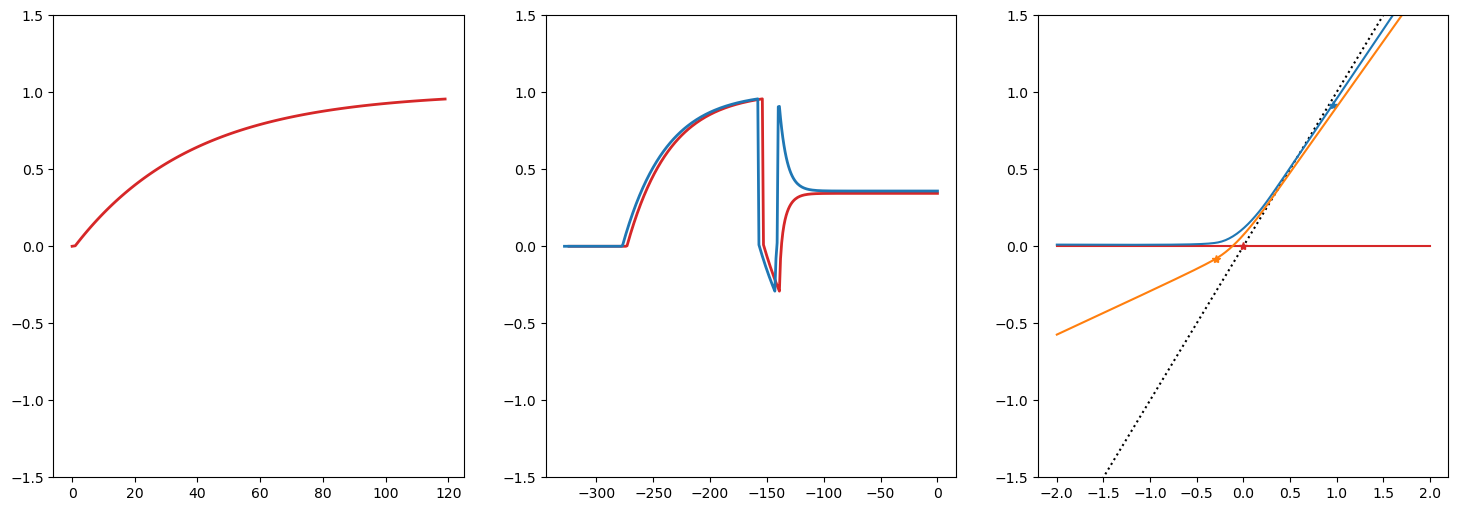

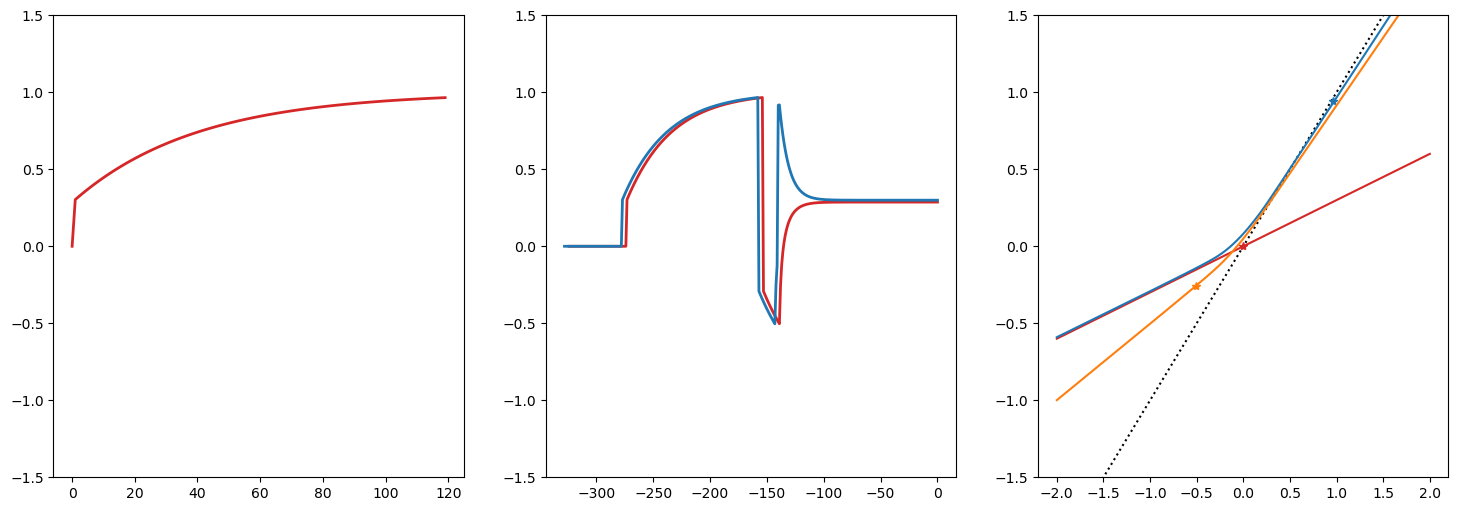

In [232]:
for i,w in enumerate(ws):
    for s,skip in enumerate(skips):
        item = (s,i)
        do_plots(results[item],playlist)


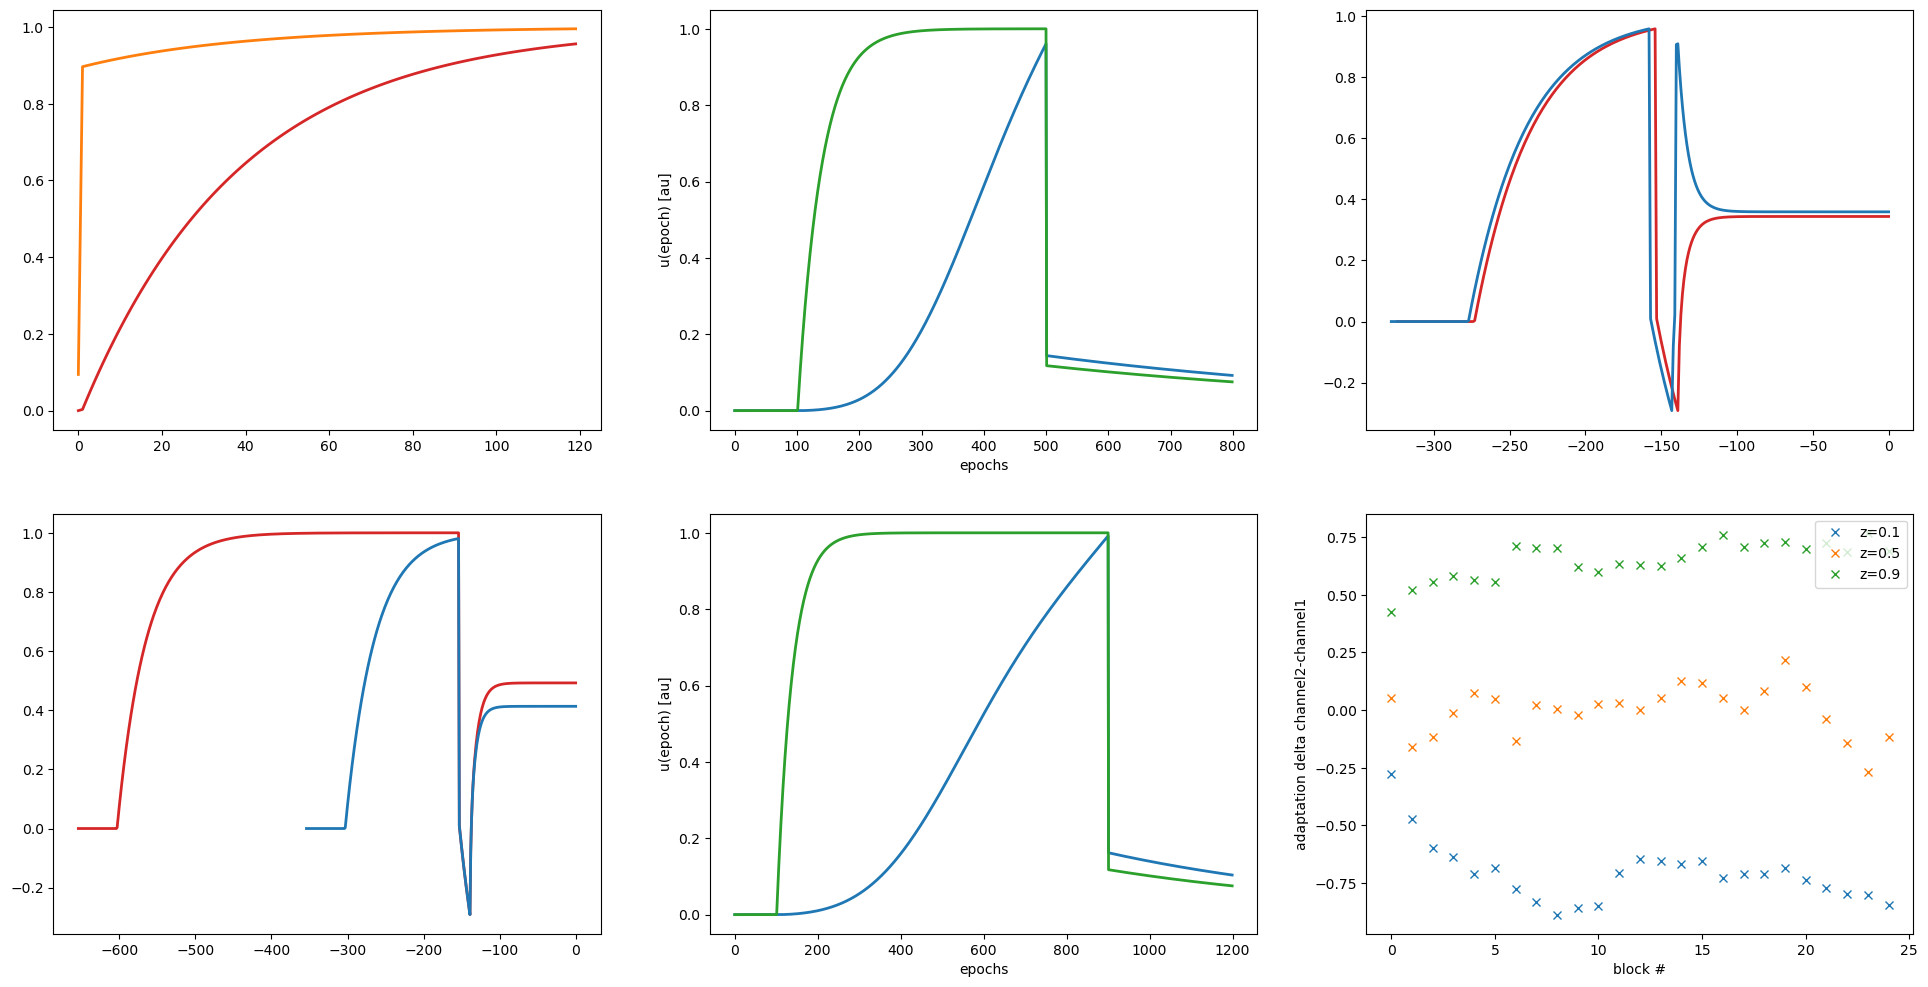

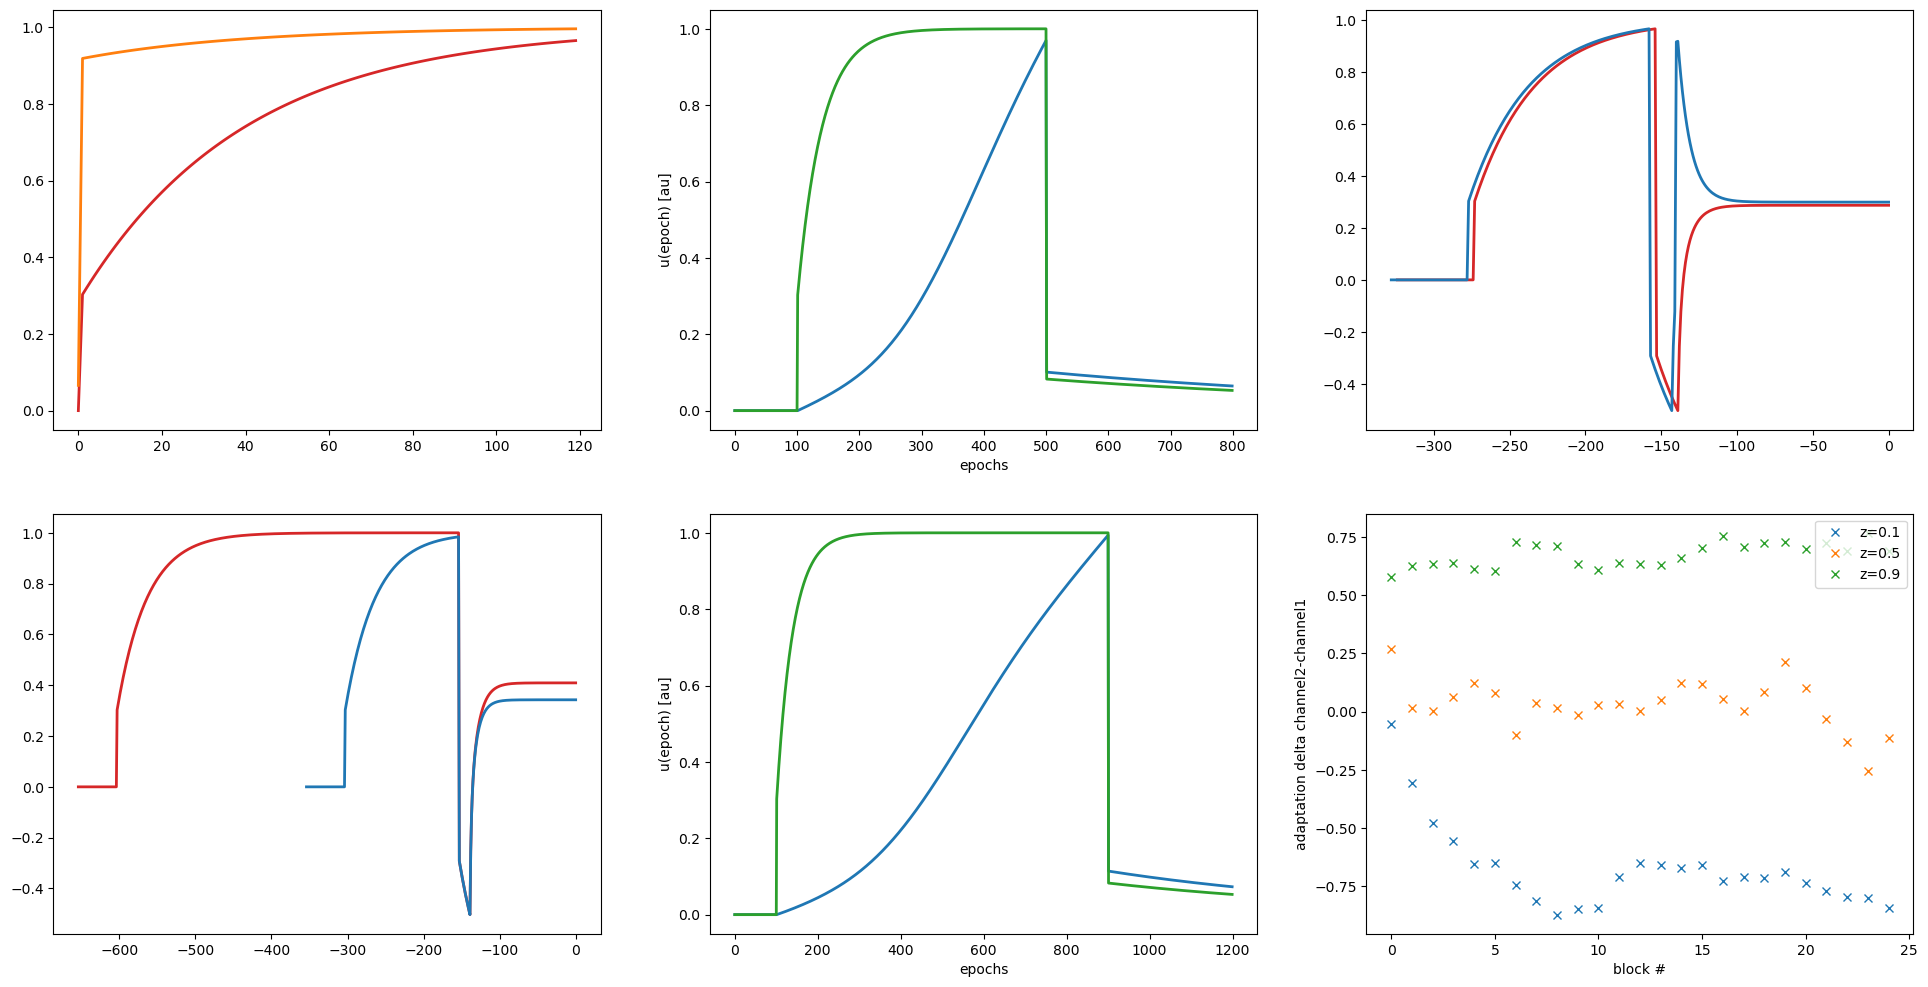

In [233]:
for i,w in enumerate(ws):
    for s,skip in enumerate(skips):
        item = (s,i)
        do_plots_full(results[item],playlist)


In [261]:
#generating plots according to the plot_spec
def do_plots_spec(results,playlist,plot_spec, default_plot_spec=None):
#prepare figure; number of lines is len(plot_spec)
#each line will have 3 subplots: stimulus, model output, xtest plot
#if paradigm is a list then all paradigms from the list are plotted.
#depending on whether paradigm_plot_opts is 'stacked' or 'separate' the plots are either stacked or separate within the subplot axis
#depending on whether model_plot_opts is 'stacked' or 'together' the plots are either stacked or together within the subplot axis
#xtest plots are taken at times that correspond to end of segment of the playlist that is specified in (<paradigm>,<segment>) in in_out_plot_content
    n_lines = len(plot_spec)
    plt.figure(figsize=(9, 3*n_lines))
    for i, spec in enumerate(plot_spec):
        if default_plot_spec is not None:
            spec = {**default_plot_spec, **spec}
        plt.subplot(n_lines,3,3*i+1)
        paradigm = spec['paradigm']
        paradigm_plot_opts = spec['paradigm_plot_opts']
        model_plot_opts = spec['model_plot_opts']
        in_out_plot_content = spec['in_out_plot_content']
        if type(paradigm) is not list:
            paradigms = [paradigm]
        else:
            paradigms = paradigm

        for paradigm in paradigms:
            y_data = parse_samples(playlist[paradigm])
            if spec['paradigm_plot_interval'] is not None:
                y_data = y_data[spec['paradigm_plot_interval'][0]:spec['paradigm_plot_interval'][1]]
            plt.plot(y_data)#,paradigm_plot_opts)
            

        plt.subplot(n_lines,3,3*i+2)
        for paradigm in paradigms:
            if spec['plot_blocks']:
                y_data = compute_herzfeld_probes(results[paradigm],playlist[paradigm],hrz_params)
            #     plt.plot(deltas,label=paradigm)
            # plt.legend()
            else:
                # plot_by_key(results,paradigms,colors=['tab:red','tab:blue','tab:orange','tab:green'],visu_offsets=[0]*10)#,model_plot_opts)
                y_data = results[paradigm].u_lp
            plt.plot(y_data)


        plt.subplot(n_lines,3,3*i+3)
        
        for paradigm, segment in in_out_plot_content:
            #compute time at the end of the segment
            pointer = 0
            for bb in range(segment+1):
                pointer += playlist[paradigm][bb][-1]
            print(paradigm,segment,i,pointer)
            
            # colors = ['tab:red','tab:blue','tab:orange','tab:green']
            # for i,time in enumerate(times):
            u_test = results[paradigm].test_output[pointer-1]
            if spec['in_out_plot_type'] == 'xy':
                ydata = u_test
                fpline = x_test
            elif spec['in_out_plot_type'] == 'xdeltay':
                ydata = u_test.reshape(-1)-x_test.reshape(-1)
                fpline = 0*x_test
            plt.plot(x_test,ydata)

            plt.plot(x_test,fpline,'k:')

            # plt.plot(x_test,u_test)#,colors[i])

        # plt.xlim([0.5*Pminus,1.5*Pplus])
        # plt.ylim([0.5*Pminus,1.5*Pplus])





In [263]:
plot_spec =[dict(paradigm='savings', paradigm_plot_opts=None, model_plot_opts=None, 
                 in_out_plot_content=[('savings',0),('savings',1),('savings',2)]),
            dict(paradigm=['frogs_long','anti_frogs_long'], paradigm_plot_opts='stacked', model_plot_opts='stacked',
                 in_out_plot_content=[('frogs_long',1),('anti_frogs_long',1)]),
            dict(paradigm=['sprecovery','evrecovery'], paradigm_plot_opts='separate', model_plot_opts='stacked',
                 in_out_plot_content=[('sprecovery',1),('sprecovery',2)],in_out_plot_type='xdeltay'),
            dict(paradigm=['spOVRrecovery','spOVRrecovery_ref'], paradigm_plot_opts='separate', model_plot_opts='stacked',
                 in_out_plot_content=[('spOVRrecovery',1),('spOVRrecovery_ref',1)],in_out_plot_type='xdeltay'),
            dict(paradigm=[f'herzfeld,z={z}' for z in hrz_params['z_list']], paradigm_plot_opts='separate', model_plot_opts='stacked',
            in_out_plot_content=[], plot_blocks=True, paradigm_plot_interval=[0,70]),]

default_plot_spec = dict(in_out_plot_content=[], plot_blocks=False, in_out_plot_type='xy',paradigm_plot_interval=None)

savings 0 0 120
savings 1 0 240
savings 2 0 360
frogs_long 1 1 900
anti_frogs_long 1 1 900
sprecovery 1 2 170
sprecovery 2 2 185
spOVRrecovery 1 3 500
spOVRrecovery_ref 1 3 200


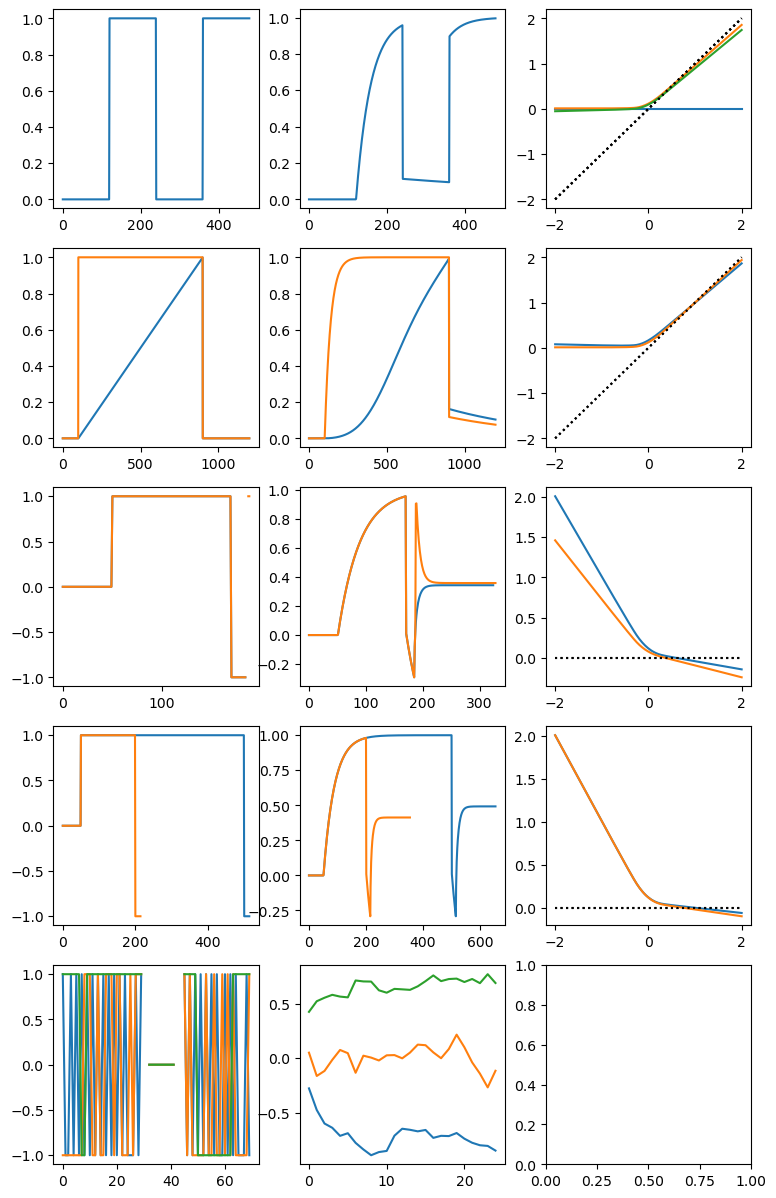

In [264]:
do_plots_spec(results[(0,0)],playlist,plot_spec,default_plot_spec=default_plot_spec)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_plot_data(results, playlist, plot_spec, default_plot_spec=None):
    """
    Extracts x,y data pairs from simulation results according to plot_spec.
    
    Returns a list (one element per spec/row) where each element is a dict with keys:
      - "stimulus": a list of dicts with keys "x", "y", "label", and optionally "plot_opts"
      - "model_output": similar structure as stimulus
      - "xtest": a list of dicts with keys "x", "y", "label", and optionally "line_opts"
    """
    plot_data = []
    for spec in plot_spec:
        # Merge with default spec if provided
        if default_plot_spec is not None:
            spec = {**default_plot_spec, **spec}
            
        row_data = {"stimulus": [], "model_output": [], "xtest": []}
        
        # Ensure paradigms is a list.
        paradigms = spec['paradigm'] if isinstance(spec['paradigm'], list) else [spec['paradigm']]
        
        # --- Stimulus data ---
        for paradigm in paradigms:
            y_data = parse_samples(playlist[paradigm])
            if spec.get('paradigm_plot_interval') is not None:
                start, end = spec['paradigm_plot_interval']
                y_data = y_data[start:end]
            # Add x-data as np.arange
            x_data = np.arange(len(y_data))
            row_data["stimulus"].append({
                "x": x_data,
                "y": y_data,
                "label": paradigm,
                "plot_opts": spec.get('paradigm_plot_opts') or {}
            })
        
        # --- Model output data ---
        for paradigm in paradigms:
            if spec.get('plot_blocks'):
                # hrz_params is assumed to be defined globally
                y_data = compute_herzfeld_probes(results[paradigm], playlist[paradigm], hrz_params)
            else:
                y_data = results[paradigm].u_lp
            x_data = np.arange(len(y_data))
            row_data["model_output"].append({
                "x": x_data,
                "y": y_data,
                "label": paradigm,
                "plot_opts": spec.get('model_plot_opts') or {}
            })
        
        # --- xtest data ---
        for paradigm, segment in spec.get('in_out_plot_content', []):
            pointer = 0
            for bb in range(segment + 1):
                pointer += playlist[paradigm][bb][-1]
            u_test = results[paradigm].test_output[pointer - 1]
            if spec.get('in_out_plot_type') == 'xy':
                y_data = u_test
                fpline = x_test  # Assumes x_test is defined globally
            elif spec.get('in_out_plot_type') == 'xdeltay':
                y_data = u_test.reshape(-1) - x_test.reshape(-1)
                fpline = np.zeros_like(x_test)
            else:
                y_data = u_test
                fpline = x_test
            x_data = x_test
            row_data["xtest"].append({
                "x": x_data,
                "y": y_data,
                "label": f"xtest {paradigm} seg {segment}",
                "line_opts": {}
            })
            row_data["xtest"].append({
                "x": x_data,
                "y": fpline,
                "label": f"fpline {paradigm} seg {segment}",
                "line_opts": {"linestyle": ":", "color": "k"}
            })
        
        plot_data.append(row_data)
    
    return plot_data



def plot_data_pairs(plot_data):
    """
    Plots the data pairs created by extract_plot_data.
    Creates a figure with three subplots per row corresponding to stimulus, model output, and xtest data.
    """
    n_lines = len(plot_data)
    plt.figure(figsize=(9, 3 * n_lines))
    
    for i, row_data in enumerate(plot_data):
        # --- Plot stimulus data ---
        ax1 = plt.subplot(n_lines, 3, 3 * i + 1)
        for series in row_data["stimulus"]:
            opts = series.get("plot_opts") or {}
            # Ensure opts is a dict
            if not isinstance(opts, dict):
                opts = {}
            plt.plot(series["x"], series["y"], label=series.get("label"), **opts)
        plt.title("Stimulus")
        plt.legend()
        
        # --- Plot model output data ---
        ax2 = plt.subplot(n_lines, 3, 3 * i + 2)
        for series in row_data["model_output"]:
            opts = series.get("plot_opts") or {}
            if not isinstance(opts, dict):
                opts = {}
            plt.plot(series["x"], series["y"], label=series.get("label"), **opts)
        plt.title("Model Output")
        plt.legend()
        
        # --- Plot xtest data ---
        ax3 = plt.subplot(n_lines, 3, 3 * i + 3)
        for series in row_data["xtest"]:
            opts = series.get("line_opts") or {}
            if not isinstance(opts, dict):
                opts = {}
            plt.plot(series["x"], series["y"], label=series.get("label"), **opts)
        plt.title("XTest")
        plt.legend()
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_495261/3595392735.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


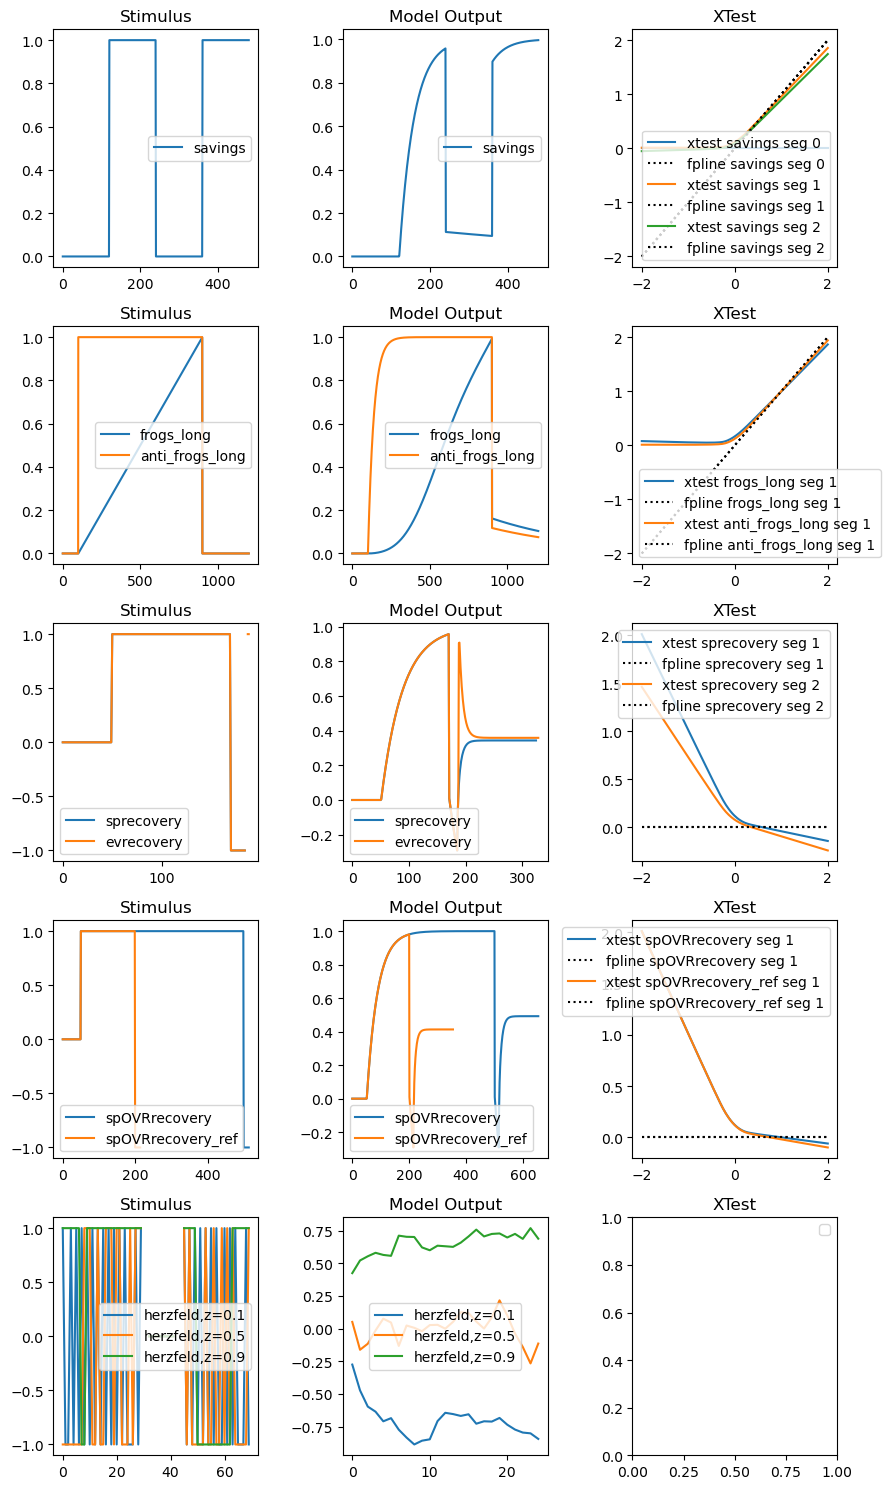

In [271]:
# First, extract the data
plot_data = extract_plot_data(results[(0,0)],playlist,plot_spec,default_plot_spec=default_plot_spec)

# Then, plot the data
plot_data_pairs(plot_data)

In [284]:
import os
import numpy as np

def escape_latex(text):
    """
    Escape underscores in text for LaTeX.
    """
    return text.replace('_', r'\_')

def generate_latex_and_csv(plot_data, csv_path="./"):
    """
    Generates CSV files for each data series in plot_data and returns a LaTeX pgfplots document as a string.

    The CSV file names are wrapped in \detokenize{} to avoid issues with underscores.
    All titles, captions, and legend entries are escaped to handle underscores.
    
    Parameters:
        plot_data: list of rows (each row is a dict with keys "stimulus", "model_output", "xtest")
                   Each value is a list of series, where each series is a dict with:
                       - "x": x-data (1D array-like)
                       - "y": y-data (1D array-like)
                       - "label": legend entry
        csv_path: directory where CSV files are saved (default: "./")
        
    Returns:
        A string containing the full LaTeX document.
    """
    # Ensure csv_path exists
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
    
    # Dictionary to keep track of CSV file names.
    # Keys are tuples: (row_idx, plot_type, series_idx)
    csv_filenames = {}
    
    # Write CSV files for each series
    for row_idx, row in enumerate(plot_data):
        for plot_type in ["stimulus", "model_output", "xtest"]:
            series_list = row.get(plot_type, [])
            for series_idx, series in enumerate(series_list):
                # File name example: row_0_stimulus_0.csv
                csv_filename = f"row_{row_idx}_{plot_type}_{series_idx}.csv"
                full_csv_path = os.path.join(csv_path, csv_filename)
                # Stack x and y data as two columns.
                data = np.column_stack((series["x"], series["y"]))
                np.savetxt(full_csv_path, data, delimiter=",", header="x,y", comments='')
                csv_filenames[(row_idx, plot_type, series_idx)] = csv_filename

    # Begin building the LaTeX document.
    latex_lines = []
    latex_lines.append(r"\documentclass{article}")
    latex_lines.append(r"\usepackage{pgfplots}")
    latex_lines.append(r"\pgfplotsset{compat=1.17}")
    latex_lines.append(r"\usepackage{subcaption}")
    # Define a macro for the CSV path; escape underscores in the csv_path if needed.
    escaped_csv_path = escape_latex(csv_path)
    latex_lines.append(r"\newcommand{\csvpath}{" + escaped_csv_path + r"}")
    latex_lines.append(r"\begin{document}")
    
    # For each row in the plot data, create a figure with three subfigures.
    for row_idx, row in enumerate(plot_data):
        latex_lines.append(r"\begin{figure}[ht]")
        latex_lines.append(r"\centering")
        for plot_type in ["stimulus", "model_output", "xtest"]:
            # Escape the plot type for title and caption.
            escaped_plot_type = escape_latex(plot_type)
            latex_lines.append(r"\begin{subfigure}[b]{0.3\textwidth}")
            latex_lines.append(r"\centering")
            latex_lines.append(r"\begin{tikzpicture}")
            latex_lines.append(r"\begin{axis}[width=\linewidth, title={" + escaped_plot_type + r"}]")
            
            series_list = row.get(plot_type, [])
            for series_idx, series in enumerate(series_list):
                label = series.get("label", "")
                escaped_label = escape_latex(label)
                csv_filename = csv_filenames.get((row_idx, plot_type, series_idx), "")
                # Use \detokenize to protect the file name (and \csvpath) from underscore issues.
                latex_lines.append(
                    r"\addplot table [x index=0, y index=1, col sep=comma] {\detokenize{\csvpath/" 
                    + csv_filename + r"}};"
                )
                latex_lines.append(r"\addlegendentry{" + escaped_label + r"}")
            
            latex_lines.append(r"\end{axis}")
            latex_lines.append(r"\end{tikzpicture}")
            latex_lines.append(r"\caption{" + escaped_plot_type + r"}")
            latex_lines.append(r"\end{subfigure}")
        latex_lines.append(r"\caption{Row " + str(row_idx) + r"}")
        latex_lines.append(r"\end{figure}")
    
    latex_lines.append(r"\end{document}")
    
    latex_document = "\n".join(latex_lines)
    return latex_document

# Example usage:
# plot_data = extract_plot_data(results, playlist, plot_spec, default_plot_spec)
# latex_doc = generate_latex_and_csv(plot_data, csv_path="data/big_fig101/")
# with open("plots.tex", "w") as f:
#     f.write(latex_doc)


In [285]:
!pwd

/homes/ar2342


In [286]:
latex_doc = generate_latex_and_csv(plot_data, csv_path="./csv_data102/")

In [287]:
print(latex_doc)

\documentclass{article}
\usepackage{pgfplots}
\pgfplotsset{compat=1.17}
\usepackage{subcaption}
\newcommand{\csvpath}{./csv\_data101/}
\begin{document}
\begin{figure}[ht]
\centering
\begin{subfigure}[b]{0.3\textwidth}
\centering
\begin{tikzpicture}
\begin{axis}[width=\linewidth, title={stimulus}]
\addplot table [x index=0, y index=1, col sep=comma] {\detokenize{\csvpath/row_0_stimulus_0.csv}};
\addlegendentry{savings}
\end{axis}
\end{tikzpicture}
\caption{stimulus}
\end{subfigure}
\begin{subfigure}[b]{0.3\textwidth}
\centering
\begin{tikzpicture}
\begin{axis}[width=\linewidth, title={model\_output}]
\addplot table [x index=0, y index=1, col sep=comma] {\detokenize{\csvpath/row_0_model_output_0.csv}};
\addlegendentry{savings}
\end{axis}
\end{tikzpicture}
\caption{model\_output}
\end{subfigure}
\begin{subfigure}[b]{0.3\textwidth}
\centering
\begin{tikzpicture}
\begin{axis}[width=\linewidth, title={xtest}]
\addplot table [x index=0, y index=1, col sep=comma] {\detokenize{\csvpath/row_0_xt

In [304]:
import os
import numpy as np

def escape_latex(text):
    """
    Escape underscores (and other characters as needed) for LaTeX.
    """
    return text.replace('_', r'\_')

def generate_latex_with_nodes(plot_data, csv_path="./", color_orders=None):
    """
    Generates CSV files for each data series in plot_data and a LaTeX pgfplots
    document that uses nodes and anchors to arrange the plots in a grid.

    The grid is organized so that each row in plot_data becomes one row and
    each plot type ("stimulus", "model_output", "xtest") is placed in a separate column.

    Parameters:
        plot_data: list of rows (each row is a dict with keys "stimulus", "model_output", "xtest")
                   where each value is a list of series dictionaries having keys:
                     - "x": x-data (1D array-like)
                     - "y": y-data (1D array-like)
                     - "label": legend entry
        csv_path: directory where CSV files are saved (default: "./")
        
    Returns:
        A string containing the complete LaTeX document.
    """
    if color_orders is None:
        color_orders = {}
        color_orders["stimulus"] = ["red", "blue", "orange", "green"]
        color_orders["model_output"] = ["red", "blue", "orange", "green"]
        color_orders["xtest"] =     ["pink", "cyan", "magenta", "yellow", "green", "blue", "orange"]

    # Ensure the CSV directory exists.
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
    
    # Write CSV files (keys: (row, plot_type, series_index))
    csv_filenames = {}
    for row_idx, row in enumerate(plot_data):
        for ptype in ["stimulus", "model_output", "xtest"]:
            series_list = row.get(ptype, [])
            for series_idx, series in enumerate(series_list):
                csv_filename = f"row_{row_idx}_{ptype}_{series_idx}.csv"
                full_csv_path = os.path.join(csv_path, csv_filename)
                data = np.column_stack((series["x"], series["y"]))
                np.savetxt(full_csv_path, data, delimiter=",", header="x,y", comments='')
                csv_filenames[(row_idx, ptype, series_idx)] = csv_filename

    # Begin building the LaTeX document.
    latex_lines = []
    latex_lines.append(r"\documentclass{article}")
    latex_lines.append(r"\usepackage{pgfplots}")
    latex_lines.append(r"\pgfplotsset{compat=1.17}")
    latex_lines.append(r"\usepackage{tikz}")
    latex_lines.append(r"\usepackage{ifthen}")
    latex_lines.append(r"\usepackage{pgffor}")
    latex_lines.append("")
    # Helper macros (as in your example)
    latex_lines.append(r"\newcommand{\lefttick}[1]{%")
    latex_lines.append(r"  \ifnum#1=1 ytick={-1,0,1},yticklabels={-1,0,1}\else")
    latex_lines.append(r"   \ifnum#1=5 ytick={-1,0,1},yticklabels={-1,0,1}\else")
    latex_lines.append(r"    \ifnum#1=9 ytick={-1,0,1},yticklabels={-1,0,1}\else")
    latex_lines.append(r"     \ifnum#1=13 ytick={-1,0,1},yticklabels={-1,0,1}\else")
    latex_lines.append(r"     ytick={},yticklabels={}\fi\fi\fi\fi")
    latex_lines.append(r"}")
    latex_lines.append("")
    latex_lines.append(r"\newcommand{\bottomtick}[1]{%")
    latex_lines.append(r"  \ifnum#1>12 xtick={0,340},xticklabels={0,340},xlabel={trials}\fi")
    latex_lines.append(r"}")
    latex_lines.append("")
    latex_lines.append(r"\newcommand{\plotoptions}[1]{%")
    latex_lines.append(r"  width=3.3cm, height=3cm,")
    latex_lines.append(r"  xmin=0, xmax=340, ymin=-1.2, ymax=1.2,")
    latex_lines.append(r"  \lefttick{#1},")
    latex_lines.append(r"  \bottomtick{#1}")
    latex_lines.append(r"}")
    latex_lines.append("")
    # Define CSV path macro (escaping special characters)
    escaped_csv_path = escape_latex(csv_path)
    # latex_lines.append(r"\newcommand{\csvpath}{" + escaped_csv_path + r"}")
    latex_lines.append("")
    latex_lines.append(r"\begin{document}")
    latex_lines.append('\xdef\csvpath{\detokenize{data/big_fig101}}')
    latex_lines.append(r"\begin{tikzpicture}[remember picture]")
    latex_lines.append("")
    
    # Set up grid dimensions: one row per element of plot_data and three columns (one per plot type)
    n_rows = len(plot_data)
    n_cols = 3
    # Spacing: adjust these as needed (cm)
    x_spacing = 2.8
    y_spacing = 2.5
    
    # Mapping from column index to plot type and title.
    plot_types = ["stimulus", "model_output", "xtest"]
    plot_titles = {"stimulus": "Stimulus", "model_output": "Model Output", "xtest": "Xtest"}
    
    # Loop over each cell and generate a node with its tikzpicture and axis.
    for row_idx, row in enumerate(plot_data):
        for col_idx, ptype in enumerate(plot_types):
            node_index = 3 * row_idx + col_idx + 1
            xcoord = col_idx * x_spacing
            ycoord = -row_idx * y_spacing
            # Begin node
            latex_lines.append(rf"\node[anchor=north west] at ({xcoord}cm, {ycoord}cm) {{")
            latex_lines.append(r"  \begin{tikzpicture}")
            latex_lines.append(r"    \begin{axis}[")
            latex_lines.append(r"      \plotoptions{" + str(node_index) + r"},")
            latex_lines.append(r"      title={" + escape_latex(plot_titles[ptype]) + r"}")
            latex_lines.append(r"    ]")
            # Insert an \addplot for each series in this cell.
            series_list = row.get(ptype, [])
            for series_idx, series in enumerate(series_list):
                label = series.get("label", "")
                escaped_label = escape_latex(label)
                csv_filename = csv_filenames.get((row_idx, ptype, series_idx), "")
                print(ptype, series_idx, csv_filename)
                latex_lines.append(
                    r"      \addplot [no markers, color=" + color_orders[ptype][series_idx] +r", ultra thick, opacity=0.5] table [x index=0, y index=1, col sep=comma] {\csvpath\detokenize{/" + csv_filename + r"}};"
                )
                # latex_lines.append(r"      \addlegendentry{" + escaped_label + r"}")
            latex_lines.append(r"    \end{axis}")
            latex_lines.append(r"  \end{tikzpicture}")
            latex_lines.append(r"};")
            latex_lines.append("")
    
    latex_lines.append(r"\end{tikzpicture}")
    latex_lines.append(r"\end{document}")
    
    latex_document = "\n".join(latex_lines)
    return latex_document

# Example usage:
# Assuming plot_data has been obtained from your extraction function,
# latex_doc = generate_latex_with_nodes(plot_data, csv_path="data/big_fig101/")
# with open("plots_nodes.tex", "w") as f:
#     f.write(latex_doc)


In [305]:
latex_doc2 = generate_latex_with_nodes(plot_data, csv_path="./csv_data102/")

stimulus 0 row_0_stimulus_0.csv
model_output 0 row_0_model_output_0.csv
xtest 0 row_0_xtest_0.csv
xtest 1 row_0_xtest_1.csv
xtest 2 row_0_xtest_2.csv
xtest 3 row_0_xtest_3.csv
xtest 4 row_0_xtest_4.csv
xtest 5 row_0_xtest_5.csv
stimulus 0 row_1_stimulus_0.csv
stimulus 1 row_1_stimulus_1.csv
model_output 0 row_1_model_output_0.csv
model_output 1 row_1_model_output_1.csv
xtest 0 row_1_xtest_0.csv
xtest 1 row_1_xtest_1.csv
xtest 2 row_1_xtest_2.csv
xtest 3 row_1_xtest_3.csv
stimulus 0 row_2_stimulus_0.csv
stimulus 1 row_2_stimulus_1.csv
model_output 0 row_2_model_output_0.csv
model_output 1 row_2_model_output_1.csv
xtest 0 row_2_xtest_0.csv
xtest 1 row_2_xtest_1.csv
xtest 2 row_2_xtest_2.csv
xtest 3 row_2_xtest_3.csv
stimulus 0 row_3_stimulus_0.csv
stimulus 1 row_3_stimulus_1.csv
model_output 0 row_3_model_output_0.csv
model_output 1 row_3_model_output_1.csv
xtest 0 row_3_xtest_0.csv
xtest 1 row_3_xtest_1.csv
xtest 2 row_3_xtest_2.csv
xtest 3 row_3_xtest_3.csv
stimulus 0 row_4_stimulus_0.

In [306]:
print(latex_doc2)

\documentclass{article}
\usepackage{pgfplots}
\pgfplotsset{compat=1.17}
\usepackage{tikz}
\usepackage{ifthen}
\usepackage{pgffor}

\newcommand{\lefttick}[1]{%
  \ifnum#1=1 ytick={-1,0,1},yticklabels={-1,0,1}\else
   \ifnum#1=5 ytick={-1,0,1},yticklabels={-1,0,1}\else
    \ifnum#1=9 ytick={-1,0,1},yticklabels={-1,0,1}\else
     \ifnum#1=13 ytick={-1,0,1},yticklabels={-1,0,1}\else
     ytick={},yticklabels={}\fi\fi\fi\fi
}

\newcommand{\bottomtick}[1]{%
  \ifnum#1>12 xtick={0,340},xticklabels={0,340},xlabel={trials}\fi
}

\newcommand{\plotoptions}[1]{%
  width=3.3cm, height=3cm,
  xmin=0, xmax=340, ymin=-1.2, ymax=1.2,
  \lefttick{#1},
  \bottomtick{#1}
}


\begin{document}
Þf\csvpath{\detokenize{data/big_fig101}}
\begin{tikzpicture}[remember picture]

\node[anchor=north west] at (0.0cm, 0.0cm) {
  \begin{tikzpicture}
    \begin{axis}[
      \plotoptions{1},
      title={Stimulus}
    ]
      \addplot [no markers, color=red, ultra thick, opacity=0.5] table [x index=0, y index=1, col sep=